In [9]:
# Import Packages
import matplotlib as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import tensorflow.keras

In [10]:
# Load Training and Testing Data from Files
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

In [11]:
# Verify Data
print('dataset: X_train:', x_train.shape, 'Y_train:', y_train.shape, 'X_test:', x_test.shape, 'Y_test', y_test.shape)

dataset: X_train: (2010, 100, 16) Y_train: (2010, 3) X_test: (990, 100, 16) Y_test (990, 3)


In [12]:
# Import Packages for Models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout, Flatten
from tensorflow.keras.layers import Input, Dense, LSTM, concatenate, Activation, Add, AveragePooling1D
from tensorflow.keras.layers import MaxPool1D

In [13]:
# Set Input Shape and Output Size
input_shape = x_train.shape[1:]
num_class = 3

In [14]:
# inception model
from tensorflow.keras.layers import Concatenate

# Function Creates an Inception Module
def _inception_module(input_tensor, stride=1, activation='linear', use_bottleneck=True, bottleneck_size=32,
                      kernel_size=40, nb_filters=32):
    if use_bottleneck and int(input_tensor.shape[-1]) > bottleneck_size:
        input_inception = Conv1D(filters=bottleneck_size, kernel_size=1,
                                 padding='same', activation=activation, use_bias=False)(input_tensor)
    else:
        input_inception = input_tensor

    kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]
    conv_list = []
    for i in range(len(kernel_size_s)):
        conv_list.append(Conv1D(filters=nb_filters, kernel_size=kernel_size_s[i], strides=stride, padding='same',
                                activation=activation, use_bias=False)(input_inception))
    max_pool_1 = MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)
    conv_6 = Conv1D(filters=nb_filters, kernel_size=1, padding='same',
                    activation=activation, use_bias=False)(max_pool_1)
    conv_list.append(conv_6)
    x = Concatenate(axis=2)(conv_list)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    return x

# Function Creates Inception Shortcut Layer
def _shortcut_layer(input_tensor, out_tensor):
    shortcut_y = Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1, padding='same', use_bias=False)(input_tensor)
    shortcut_y = BatchNormalization()(shortcut_y)
    x = Add()([shortcut_y, out_tensor])
    x = Activation('relu')(x)
    return x

# Function Creates Entire Inception Network Using Modules and Shortcut Layer
def generate_inception(INPUT_SHAPE, NB_CLASS, use_residual=True, depth=6):
    input_layer = Input(INPUT_SHAPE)
    x = input_layer
    input_res = input_layer
    for d in range(depth):
        x = _inception_module(x)
        if use_residual and d % 3 == 2:
            x = _shortcut_layer(input_res, x)
            input_res = x
    gap_layer = GlobalAveragePooling1D()(x)
    output_layer = Dense(NB_CLASS, activation='sigmoid')(gap_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Define Inception Model
inception_model = generate_inception(input_shape, num_class)

In [15]:
#ResNet Model
def generate_resnet(INPUT_SHAPE, NB_CLASS):
    n_feature_maps = 32
    input_layer = Input(INPUT_SHAPE)
    # BLOCK 1
    conv_x = Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_y = Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)
    conv_z = Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = BatchNormalization()(conv_z)
    # expand channels for the sum
    shortcut_y = Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = BatchNormalization()(shortcut_y)
    output_block_1 = Add()([shortcut_y, conv_z])
    output_block_1 = Activation('relu')(output_block_1)
    # BLOCK 2
    conv_x = Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_y = Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)
    conv_z = Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = BatchNormalization()(conv_z)
    # expand channels for the sum
    shortcut_y = Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = BatchNormalization()(shortcut_y)
    output_block_2 = Add()([shortcut_y, conv_z])
    output_block_2 = Activation('relu')(output_block_2)
    # BLOCK 3
    conv_x = Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_y = Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)
    conv_z = Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = BatchNormalization()(conv_z)
    # no need to expand channels because they are equal
    shortcut_y = BatchNormalization()(output_block_2)
    output_block_3 = Add()([shortcut_y, conv_z])
    output_block_3 = Activation('relu')(output_block_3)
    # FINAL
    gap_layer = GlobalAveragePooling1D()(output_block_3)
    output_layer = Dense(NB_CLASS, activation='sigmoid')(gap_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Define Inception Model
resnet_model = generate_resnet(input_shape, num_class)

In [16]:
#Best Threshold Calculator for Changing Nonbinary Output labels to Binary

from sklearn.metrics import matthews_corrcoef


def threshold_calibration_matthews_corrcoef(LABEL, SCORE):
    Pred = SCORE
    Truth = LABEL
    threshold = np.arange(0.1, 0.9, 0.1)
    acc = []
    accuracies = []
    best_threshold = np.zeros(Pred.shape[1])
    for i in range(Pred.shape[1]):
        y_prob = np.array(Pred[:, i])
        for j in threshold:
            y_pred = [1 if prob >= j else 0 for prob in y_prob]
            acc.append(matthews_corrcoef(Truth[:, i], y_pred))
        acc = np.array(acc)
        index = np.where(acc == acc.max())
        accuracies.append(acc.max())
        best_threshold[i] = threshold[index[0][0]]
        acc = []

    return best_threshold


In [17]:
# Import Training Optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [19]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Set Inception Training Parameters (can change batch size, number epochs, learning rate)
batch_size = 4
num_epoch = 50
learning_rate = 0.0001
mini_batch_size = int(min(x_train.shape[0] / 10, batch_size))
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, epsilon=1e-4, mode='min')
optm = Adam(learning_rate=learning_rate)


In [20]:
#START Inception Training
seq = inception_model
seq.compile(optimizer=optm, loss='binary_crossentropy', metrics=['accuracy'])
history = seq.fit(x_train, y_train,
                  batch_size=mini_batch_size,
                  epochs=num_epoch,
                  shuffle=True,
                  verbose=1,
                  validation_split=0.0,
                  validation_data=(x_train, y_train),
                  callbacks=[reduce_lr_loss])

Epoch 1/50
503/503 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5491 - loss: 0.5787 - val_accuracy: 0.2791 - val_loss: 6.1856 - learning_rate: 1.0000e-04
Epoch 2/50
503/503 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7309 - loss: 0.3381 - val_accuracy: 0.2965 - val_loss: 7.0348 - learning_rate: 1.0000e-04
Epoch 3/50
503/503 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7757 - loss: 0.2968 - val_accuracy: 0.3458 - val_loss: 11.5915 - learning_rate: 1.0000e-04
Epoch 4/50
503/503 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8206 - loss: 0.2350 - val_accuracy: 0.2871 - val_loss: 7.4457 - learning_rate: 1.0000e-04
Epoch 5/50
503/503 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8243 - loss: 0.2065 - val_accuracy: 0.5284 - val_loss: 11.2869 - learning_rate: 1.0000e-04
Epoch 6/50
503/503 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8075 - loss: 0.2087 - val_accuracy: 0.5284 - val_loss: 8.0199 - learning_rate: 1.0000e-04
Epoch 7/50
503/503 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - a

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
[1 0 0]
[1 0 0]


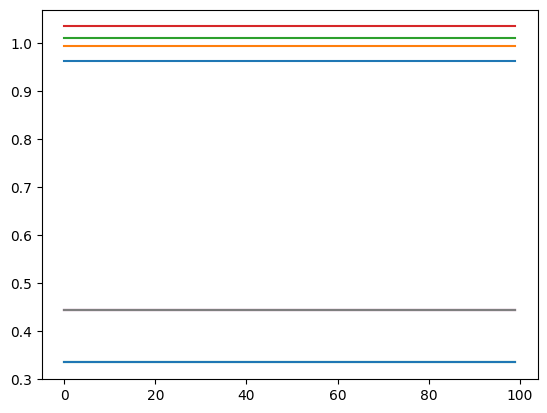


[1 0 0]
[1 0 0]


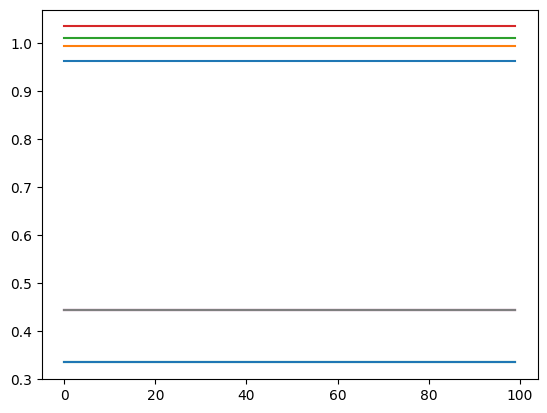


[0 1 1]
[0 1 1]


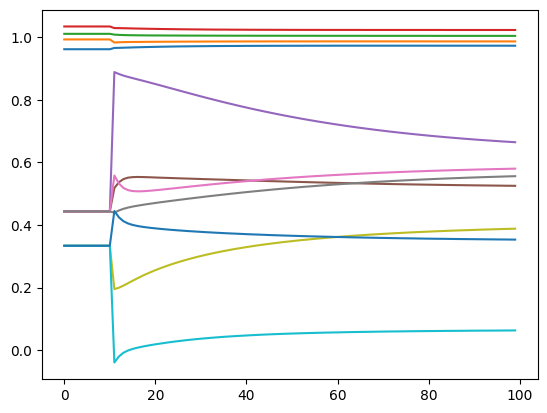


[0 0 1]
[0 0 1]


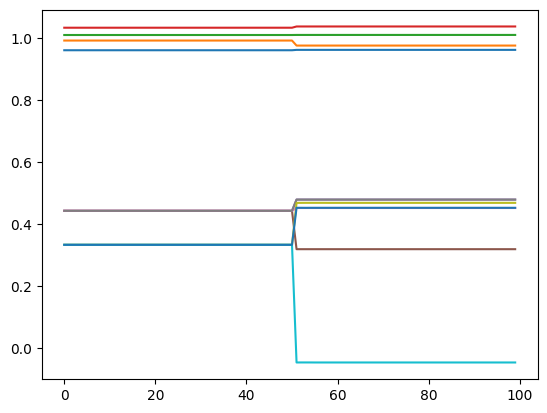


[0 0 1]
[0 0 1]


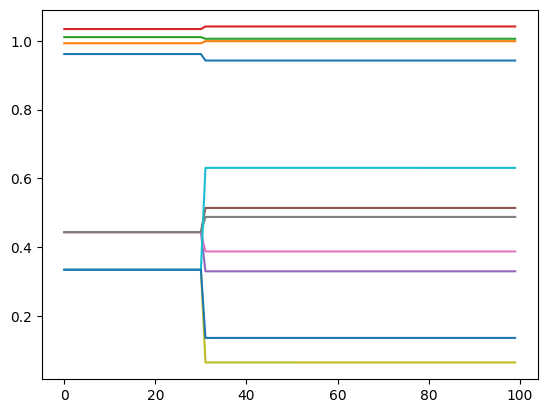


[0 0 1]
[0 0 1]


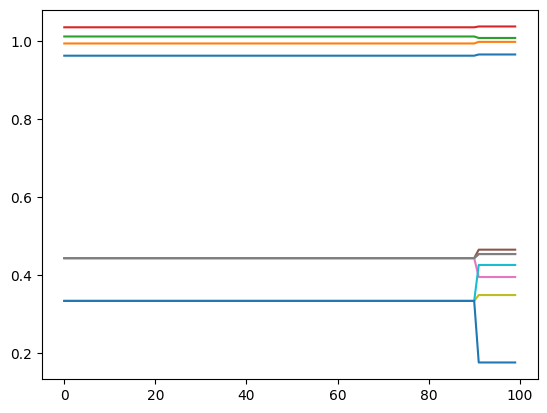


[1 0 0]
[1 0 0]


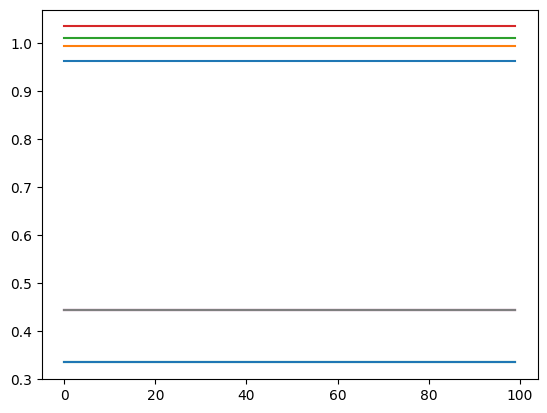


[0 0 1]
[0 0 1]


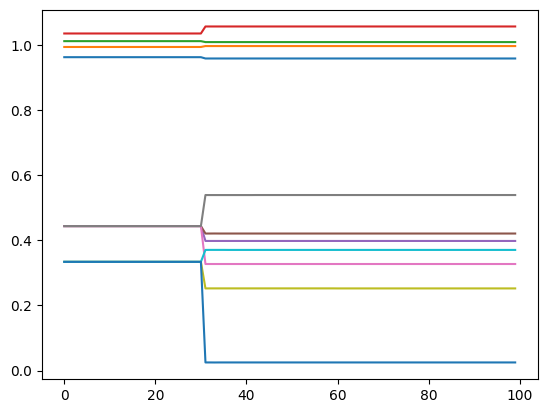


[1 0 0]
[1 0 0]


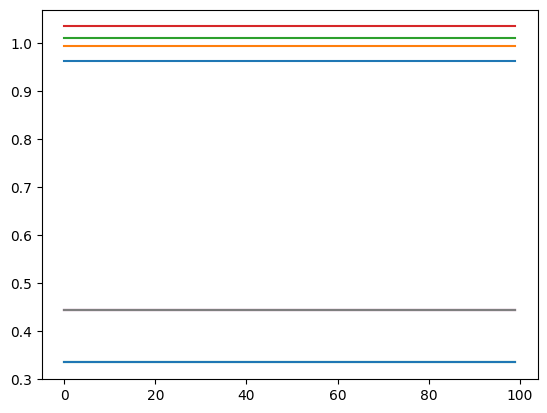


[0 1 1]
[0 1 1]


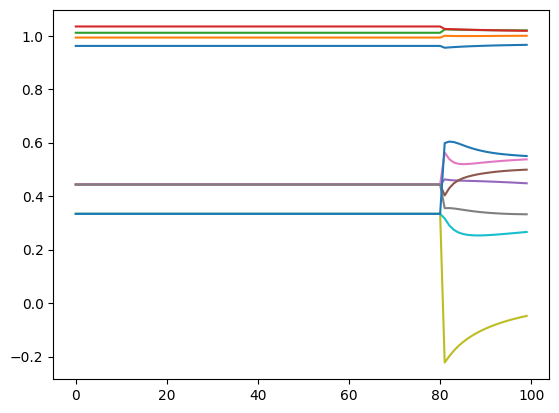


[0 1 1]
[0 1 1]


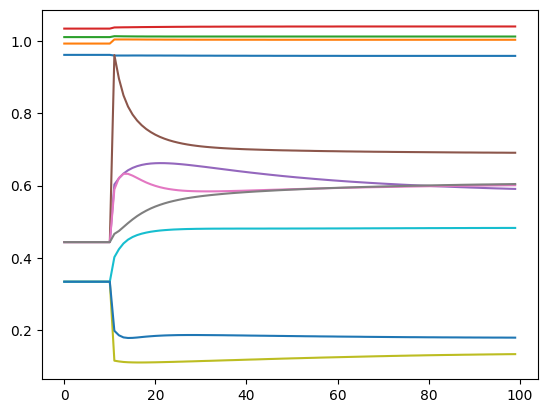


[0 1 0]
[0 1 0]


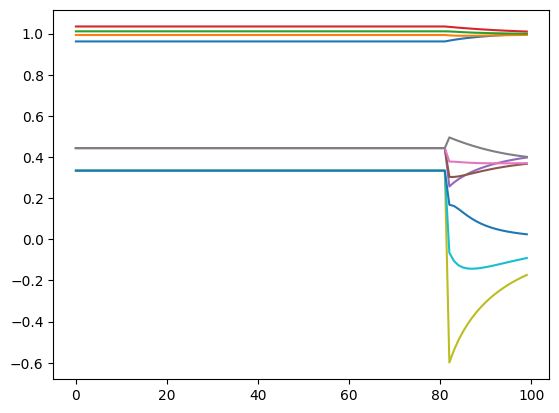


[0 1 0]
[0 1 0]


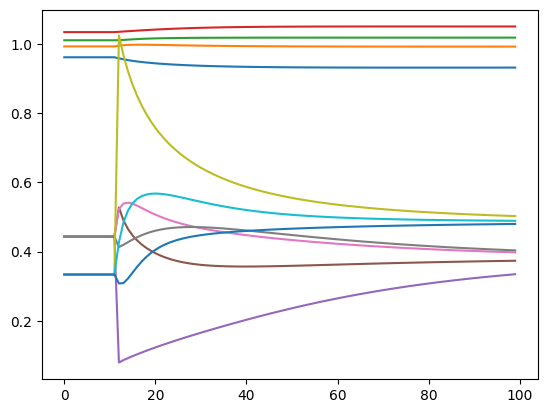


[0 1 0]
[0 1 0]


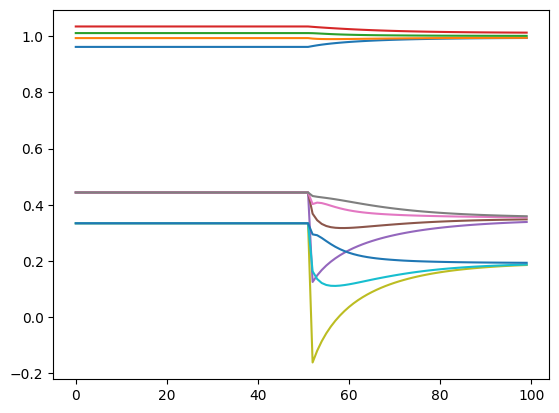


[1 0 0]
[1 0 0]


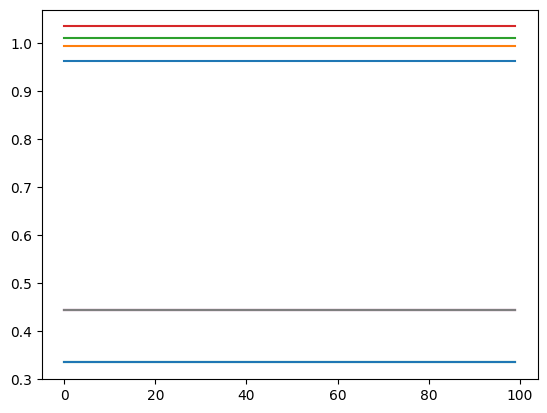


[0 0 1]
[0 0 1]


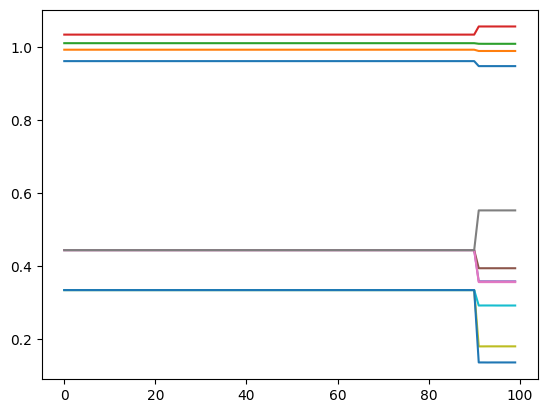


[0 1 1]
[0 1 1]


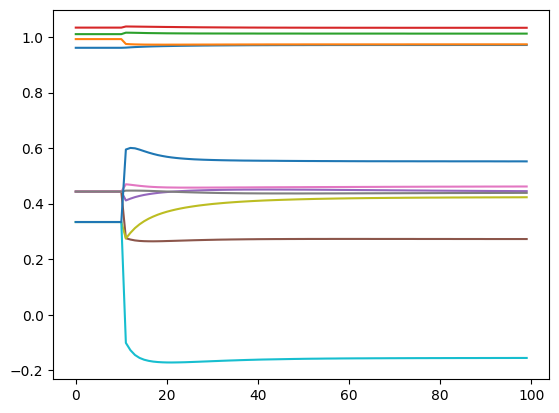


[0 1 1]
[0 1 1]


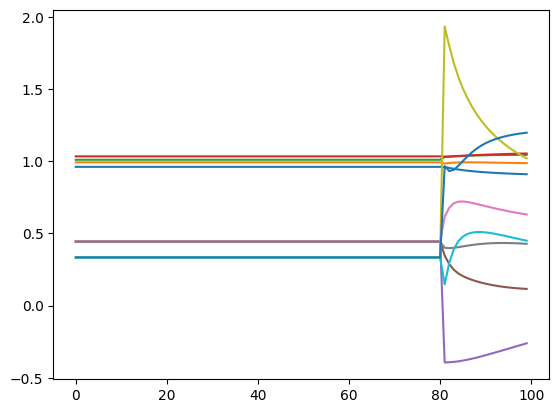


[0 1 1]
[0 1 1]


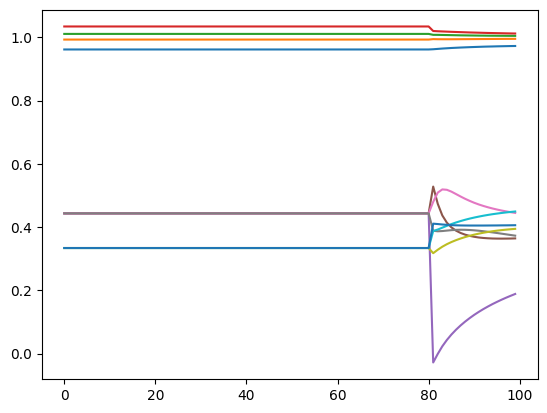


[0 0 1]
[0 0 1]


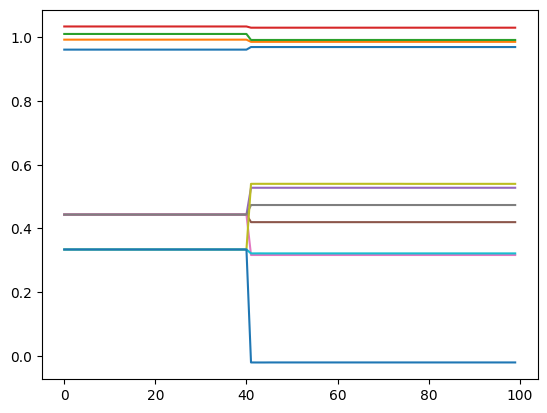


F1_score(Micro): 0.9630218687872764
F1_score(Macro): 0.9648102022079575
presicion Score(Micro): 0.9774011299435028
presicion Score(Macro): 0.9701376116657908
recall Score(Micro): 0.9490595611285266
recall Score(Macro): 0.960728557569932
Acc_score: 0.9141414141414141
[[[798  11]
  [  0 181]]

 [[417  14]
  [ 45 514]]

 [[451   3]
  [ 20 516]]]
Acc_score Normal: 0.9888888888888889
Acc_score Load Change: 0.9404040404040404
Acc_score Attack: 0.9767676767676767


In [21]:
# Inception Transform Predictions from Non-binary to Binary
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, multilabel_confusion_matrix, confusion_matrix
y_pred = inception_model.predict(x_test)
best_threshold = threshold_calibration_matthews_corrcoef(LABEL=y_train, SCORE=inception_model.predict(x_train))
y_pred_binary = np.array(
    [[1 if y_pred[i, j] >= best_threshold[j] else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])

# Graph first 's' Samples and Predictions
s = 20
for i in range (s):
    print(y_pred_binary[i])  
    print(y_test[i]) 
    plt.pyplot.plot(x_test[i,:,0:11])
    plt.pyplot.show() 
    print()

# Inception Performance
print('F1_score(Micro):', f1_score(y_test, y_pred_binary, average='micro'))
print('F1_score(Macro):', f1_score(y_test, y_pred_binary, average='macro'))
print('presicion Score(Micro):', precision_score(y_test, y_pred_binary, average='micro'))
print('presicion Score(Macro):', precision_score(y_test, y_pred_binary, average='macro'))
print('recall Score(Micro):', recall_score(y_test, y_pred_binary, average='micro'))
print('recall Score(Macro):', recall_score(y_test, y_pred_binary, average='macro'))
print('Acc_score:', accuracy_score(y_test, y_pred_binary))
print(multilabel_confusion_matrix(y_test, y_pred_binary))
print('Acc_score Normal:', accuracy_score(y_test[:,0], y_pred_binary[:,0]))
print('Acc_score Load Change:', accuracy_score(y_test[:,1], y_pred_binary[:,1]))
print('Acc_score Attack:', accuracy_score(y_test[:,2], y_pred_binary[:,2]))

In [22]:
# Save Metrics in dictionaries
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


In [26]:
pip install numpy matplotlib


Note: you may need to restart the kernel to use updated packages.


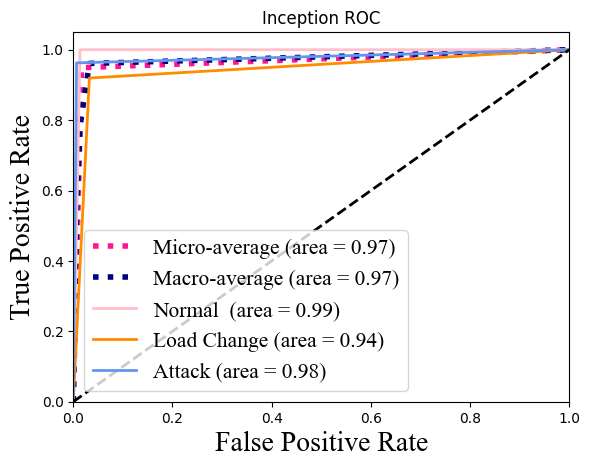

In [31]:
# Plot ROC Curves for Multilabel Inception
import numpy as np
from itertools import cycle
import matplotlib.pyplot as pyplt
from sklearn.metrics import auc

n_classes = 3
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
pyplt.figure()
pyplt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

pyplt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['pink', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
      if i == 0:
            label='Normal '
      if i == 1:
            label='Load Change'
      if i == 2:
            label='Attack'
      pyplt.plot(fpr[i], tpr[i], color=color, lw=lw,
            label=label + ' (area = {1:0.2f})'
            ''.format(i, roc_auc[i]))

pyplt.rc('font', family='Times New Roman')
pyplt.plot([0, 1], [0, 1], 'k--', lw=lw)
pyplt.xlim([0.0, 1.0])
pyplt.ylim([0.0, 1.05])
pyplt.xlabel('False Positive Rate', font='Times New Roman', fontsize=20)
pyplt.ylabel('True Positive Rate', font='Times New Roman', fontsize=20)
pyplt.title('Inception ROC')
pyplt.legend(loc="lower right")
pyplt.legend(fontsize=15.5)
pyplt.show()

In [34]:
pip install keras tensorflow


Note: you may need to restart the kernel to use updated packages.


In [35]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Set ResNet Training Parameters (can change batch size, number epochs, learning rate)
batch_size = 8
num_epoch = 25
learning_rate = 0.00001
mini_batch_size = int(min(x_train.shape[0] / 10, batch_size))
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, epsilon=1e-4, mode='min')
optm = Adam(learning_rate=learning_rate)


In [36]:
# START ResNet Training
seq = resnet_model
seq.compile(optimizer=optm, loss='binary_crossentropy', metrics=['accuracy'])
history = seq.fit(x_train, y_train,
                  batch_size=mini_batch_size,
                  epochs=num_epoch,
                  shuffle=True,
                  verbose=1,
                  validation_split=0.0,
                  validation_data=(x_train, y_train),
                  callbacks=[reduce_lr_loss])

Epoch 1/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4586 - loss: 0.6581 - val_accuracy: 0.2776 - val_loss: 21.0404 - learning_rate: 1.0000e-05
Epoch 2/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6171 - loss: 0.5593 - val_accuracy: 0.2786 - val_loss: 4.4686 - learning_rate: 1.0000e-05
Epoch 3/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6733 - loss: 0.5135 - val_accuracy: 0.3687 - val_loss: 0.7867 - learning_rate: 1.0000e-05
Epoch 4/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6941 - loss: 0.4689 - val_accuracy: 0.5313 - val_loss: 0.8616 - learning_rate: 1.0000e-05
Epoch 5/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7331 - loss: 0.4443 - val_accuracy: 0.3662 - val_loss: 0.9427 - learning_rate: 1.0000e-05
Epoch 6/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7449 - loss: 0.4274 - val_accuracy: 0.5582 - val_loss: 0.9558 - learning_rate: 1.0000e-05
Epoch 7/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accura

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[1 0 0]
[1 0 0]


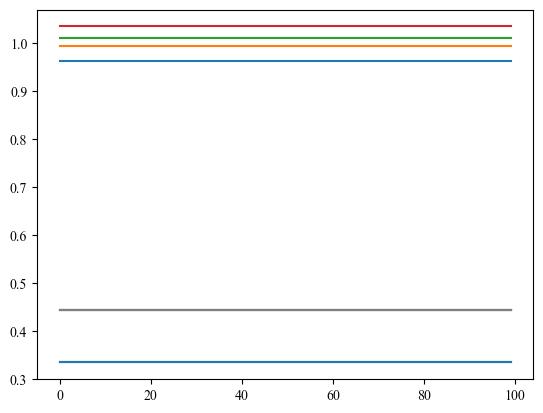


[1 0 0]
[1 0 0]


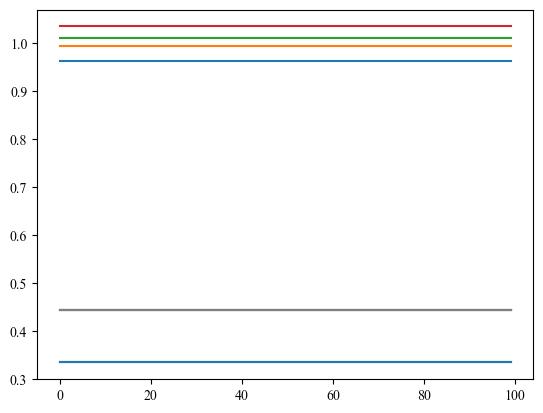


[0 1 0]
[0 1 1]


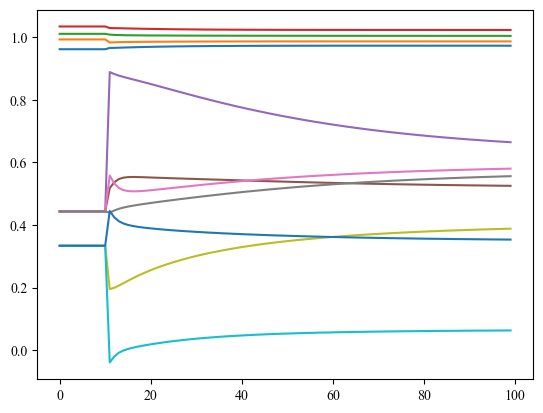


[0 0 1]
[0 0 1]


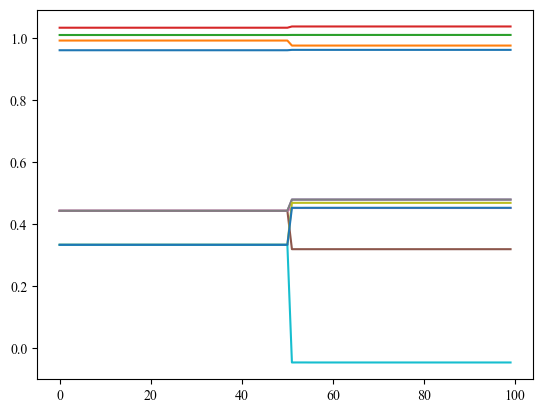


[0 0 1]
[0 0 1]


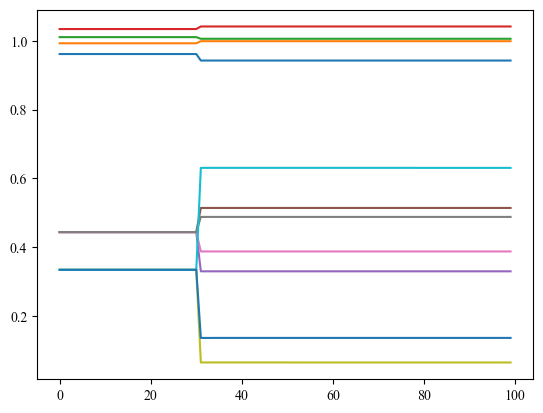


[1 0 0]
[0 0 1]


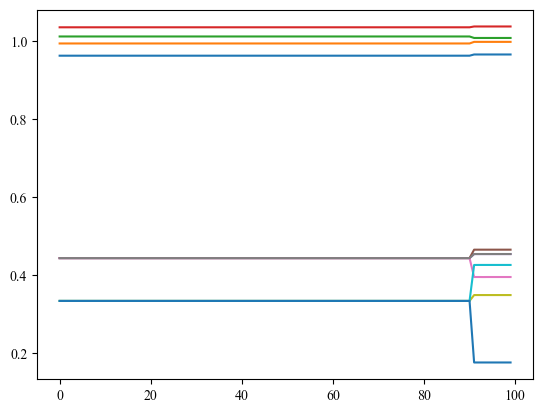


[1 0 0]
[1 0 0]


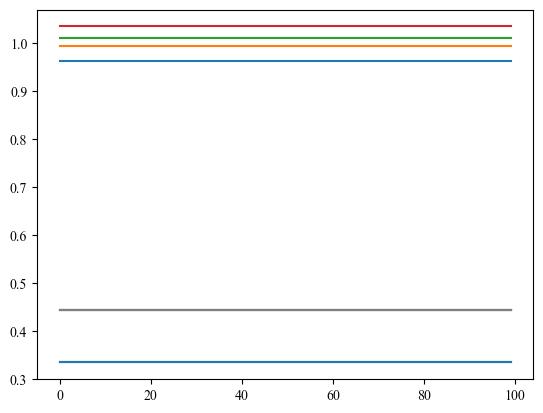


[0 0 1]
[0 0 1]


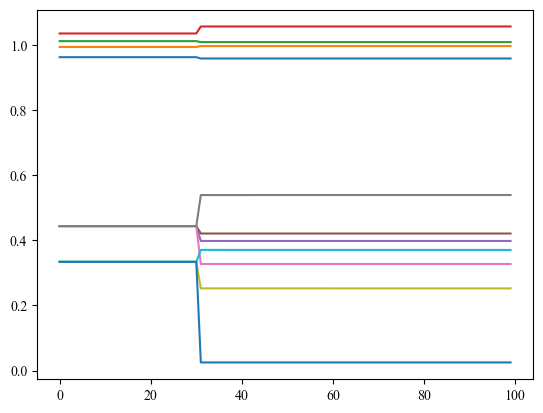


[1 0 0]
[1 0 0]


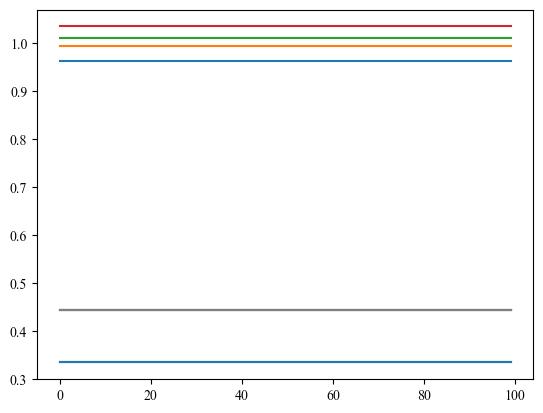


[0 1 1]
[0 1 1]


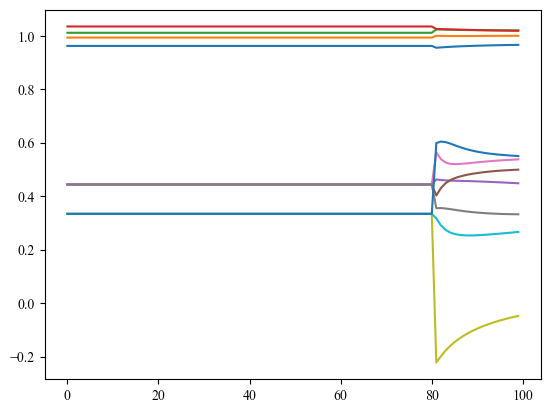


[0 1 1]
[0 1 1]


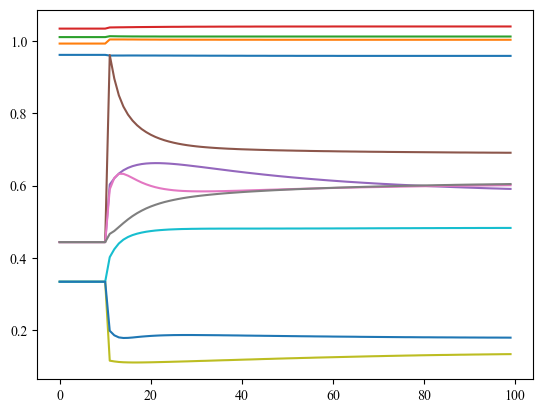


[0 1 0]
[0 1 0]


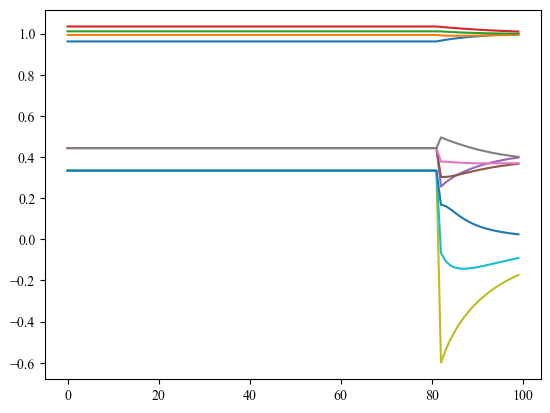


[0 1 0]
[0 1 0]


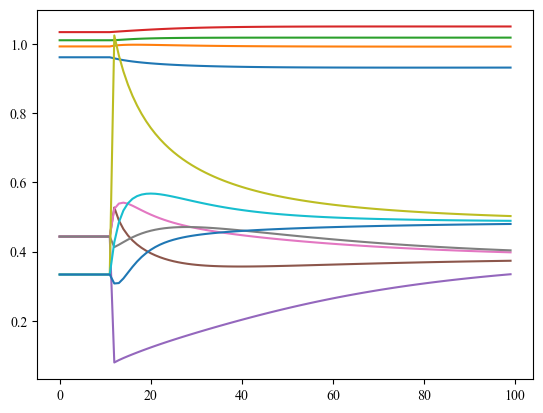


[0 1 0]
[0 1 0]


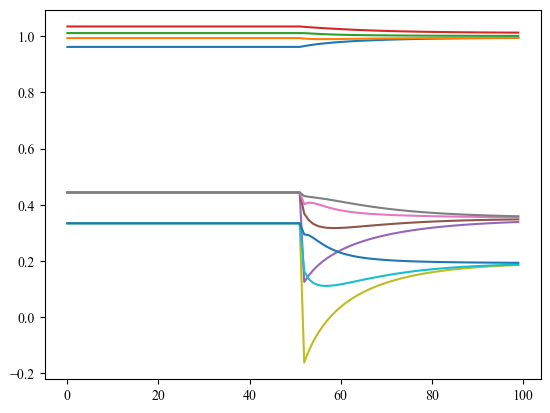


[1 0 0]
[1 0 0]


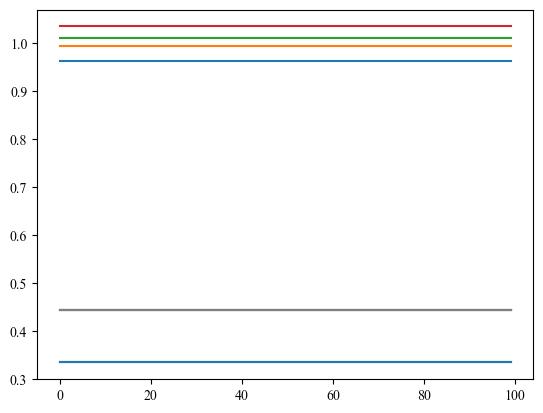


[0 1 1]
[0 0 1]


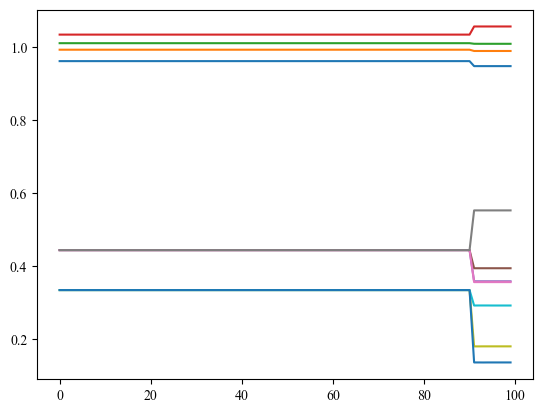


[0 0 1]
[0 1 1]


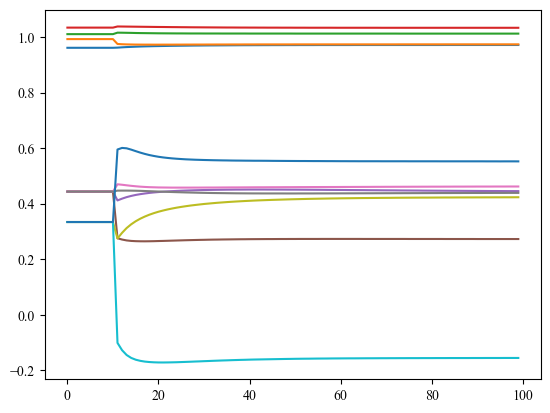


[0 1 1]
[0 1 1]


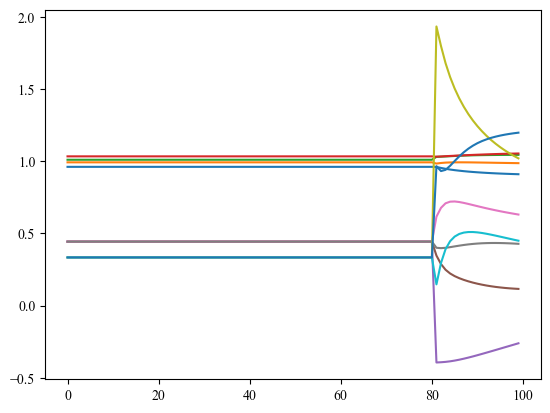


[0 1 1]
[0 1 1]


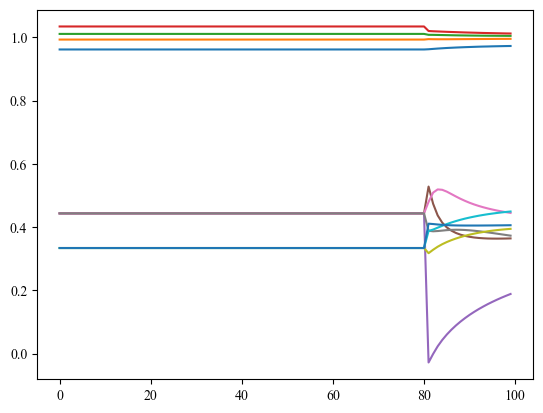


[0 1 1]
[0 0 1]


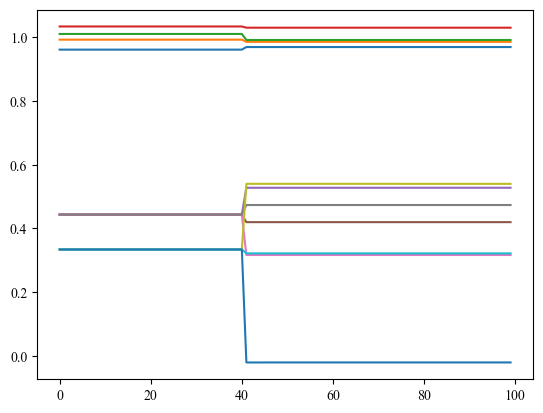


F1_score(Micro): 0.8955105284068335
F1_score(Macro): 0.8916328664986009
presicion Score(Micro): 0.9081385979049154
presicion Score(Macro): 0.885235403709022
recall Score(Micro): 0.8832288401253918
recall Score(Macro): 0.9097947204941305
Acc_score: 0.7717171717171717
[[[758  51]
  [  0 181]]

 [[404  27]
  [ 96 463]]

 [[418  36]
  [ 53 483]]]
Acc_score Normal: 0.9484848484848485
Acc_score Load Change: 0.8757575757575757
Acc_score Attack: 0.9101010101010101


In [41]:
# ResNet Transform Predictions from Non-binary to Binary
import matplotlib as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, multilabel_confusion_matrix
y_pred = resnet_model.predict(x_test)
best_threshold = threshold_calibration_matthews_corrcoef(LABEL=y_train, SCORE=resnet_model.predict(x_train))
y_pred_binary = np.array(
    [[1 if y_pred[i, j] >= best_threshold[j] else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])

# Graph first 's' Samples and Predictions
s =20
for i in range(0,s):
    print(y_pred_binary[i])  
    print(y_test[i]) 
    plt.pyplot.plot(x_test[i,:,0:11])
    plt.pyplot.show() 
    print()

# \Resnet Performance
print('F1_score(Micro):', f1_score(y_test, y_pred_binary, average='micro'))
print('F1_score(Macro):', f1_score(y_test, y_pred_binary, average='macro'))
print('presicion Score(Micro):', precision_score(y_test, y_pred_binary, average='micro'))
print('presicion Score(Macro):', precision_score(y_test, y_pred_binary, average='macro'))
print('recall Score(Micro):', recall_score(y_test, y_pred_binary, average='micro'))
print('recall Score(Macro):', recall_score(y_test, y_pred_binary, average='macro'))
print('Acc_score:', accuracy_score(y_test, y_pred_binary))
print(multilabel_confusion_matrix(y_test, y_pred_binary))
print('Acc_score Normal:', accuracy_score(y_test[:,0], y_pred_binary[:,0]))
print('Acc_score Load Change:', accuracy_score(y_test[:,1], y_pred_binary[:,1]))
print('Acc_score Attack:', accuracy_score(y_test[:,2], y_pred_binary[:,2]))

In [42]:
# Save Metrics in dictionaries
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


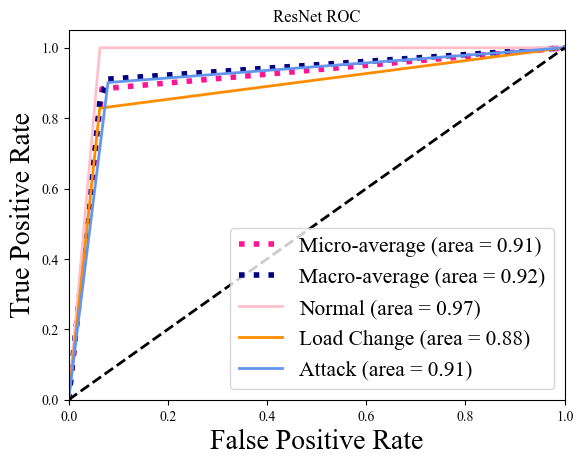

In [44]:
# Plot ROC Curves for Multilabel ResNet
import numpy as np
import matplotlib.pyplot as pyplt
from sklearn.metrics import auc
from itertools import cycle
# First aggregate all false positive rates
n_classes = 3
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
pyplt.figure()
pyplt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

pyplt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['pink', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    if i == 0:
        label = 'Normal'
    elif i == 1:
        label = 'Load Change'
    elif i == 2:
        label = 'Attack'
    pyplt.plot(fpr[i], tpr[i], color=color, lw=lw,
               label=label + ' (area = {1:0.2f})'
               ''.format(i, roc_auc[i]))

pyplt.rc('font', family='Times New Roman')
pyplt.plot([0, 1], [0, 1], 'k--', lw=lw)
pyplt.xlim([0.0, 1.0])
pyplt.ylim([0.0, 1.05])
pyplt.xlabel('False Positive Rate', font='Times New Roman', fontsize=20)
pyplt.ylabel('True Positive Rate', font='Times New Roman', fontsize=20)
pyplt.title('ResNet ROC')
pyplt.legend(loc="lower right")
pyplt.legend(fontsize=15.5)
pyplt.show()